# Neural Machine Translator model with attention mechanism

### Data extraction

In [ ]:
# !wget -O en-fa.tmx.gz https://opus.nlpl.eu/download.php?f=TEP/v1/tmx/en-fa.tmx.gz
!wget -O en-fa.txt.zip https://opus.nlpl.eu/download.php?f=TEP/v1/moses/en-fa.txt.zip
# !gzip -dk en-fa.tmx.gz
!unzip en-fa.txt.zip

In [ ]:
!cat TEP.en-fa.en | grep -a "?"

In [ ]:
!pip install "tensorflow-text==2.8.*"

In [ ]:
import pathlib
import re
import string
import typing
from typing import Any, Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow import keras

In [ ]:
text_file = keras.utils.get_file(
    fname="fa-eng.zip",
    origin="https://opus.nlpl.eu/download.php?f=TEP/v1/moses/en-fa.txt.zip",
    extract=True,
)

text_fa = pathlib.Path(text_file).parent  / "TEP.en-fa.fa"
text_en = pathlib.Path(text_file).parent  / "TEP.en-fa.en"

16367616/16353318 [==============================] - 2s 0us/step


In [ ]:
with open(text_en) as f:
  lines_en = f.read().split("\n")[:-1]

with open(text_fa) as f:
  lines_fa = f.read().split("\n")[:-1]

In [ ]:
index = 10
print(lines_en[index])
print(lines_fa[index])

assert len(lines_en) == len(lines_fa)
len(lines_en)

its the last feed weve got .
اين آخرين علوفه اي بود که ما داشتيم .


612086

In [ ]:
inp = lines_fa
targ = lines_en

limit = 200000
inp = inp[:limit]
targ = targ[:limit]

BUFFER_SIZE = len(inp)
BATCH_SIZE = 256

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[1].numpy())
  print()
  print(example_target_batch[1].numpy().decode())
  print(example_target_batch[1].numpy())

  break

b'\xd9\x8a\xd9\x83 \xd8\xb2\xd9\x85\xd8\xa7\xd9\x86\xd9\x8a \xd8\xb4\xd9\x87\xd8\xb1\xd9\x87\xd8\xa7\xd9\x8a\xd9\x8a \xd8\xa8\xd9\x87 \xda\xaf\xd8\xb3\xd8\xaa\xd8\xb1\xd8\xaf\xda\xaf\xd9\x8a \xd8\xb5\xd8\xaf\xd9\x87\xd8\xa7 \xd9\x85\xd8\xa7\xd9\x8a\xd9\x84 \xd8\xa8\xd9\x88\xd8\xaf\xd9\x87 .'

there used to be cities that spanned hundreds of miles .
b'there used to be cities that spanned hundreds of miles .'


### Data preprocessing

In [ ]:
def standardize_en(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  
  return text




def standardize_fa(text):
  strip_chars = re.sub('[\[\].?!,¿]', '', string.punctuation)

  text = tf.strings.regex_replace(text, f"[{re.escape(strip_chars)}]", '')

  text = tf.strings.regex_replace(text, '[.?!,¿،]', r' \0 ')

  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

  return text

In [ ]:
example_text = tf.constant("what is it? the captain has escaped.")
print(example_text.numpy().decode())
print(standardize_en(example_text).numpy().decode())

what is it? the captain has escaped.
[START] what is it ?  the captain has escaped . [END]


In [ ]:
strip_chars = re.sub('[\[\].?!,¿]', '', string.punctuation)
strip_chars

'"#$%&\'()*+-/:;<=>@\\^_`{|}~'

In [ ]:
re.escape(strip_chars)

'"\\#\\$%\\&\'\\(\\)\\*\\+\\-/:;<=>@\\\\\\^_`\\{\\|\\}\\~'

In [ ]:
max_vocab_size = 5000

en_vectorization = tf.keras.layers.TextVectorization(
    standardize=standardize_en,
    max_tokens=max_vocab_size
)

fa_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_size,
    standardize=standardize_fa
)

### Data tokenizing

In [ ]:
en_vectorization.adapt(targ)
en_vectorization.get_vocabulary()[:10]

['', '[UNK]', '.', '[START]', '[END]', ',', 'you', 'the', 'i', 'to']

In [ ]:
fa_vectorization.adapt(inp)
fa_vectorization.get_vocabulary()[:10]

['', '[UNK]', '.', '[START]', '[END]', '،', 'من', 'را', 'به', 'تو']

In [ ]:
fa_example_tokens = fa_vectorization(example_input_batch)
fa_example_tokens[:3]

<tf.Tensor: shape=(3, 21), dtype=int64, numpy=
array([[   3, 2077,    1,    5,    6,   27,    9, 3794,   40,    2,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   76,  543,    1,    8,    1, 2945, 1448,  210,    2,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   34,  278,    7, 4480,   12,   13, 3076,   12,   17, 2347,
        2312,   87,   20,    2,    4,    0,    0,    0,    0,    0]])>

In [ ]:
en_example_tokens = en_vectorization(example_target_batch)
en_example_tokens[:3]

<tf.Tensor: shape=(3, 24), dtype=int64, numpy=
array([[   3, 1492,    1,    5,   35,   43,  134,  237,   37,    6,    2,
           4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,   47,  334,    9,   30, 3709,   15,    1, 2312,   13, 1029,
           2,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   3,   26,    6,   68,    6,  113,   23, 4075,  147, 1166,   74,
           7, 1898,    2,    4,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])>

In [ ]:
len(fa_vectorization.get_vocabulary())

5000

In [ ]:
input_vocab = np.array(en_vectorization.get_vocabulary())
tokens = input_vocab[en_example_tokens[2].numpy()]
' '.join(tokens)

'[START] do you think you could have parked any further from the entrance . [END]         '

In [ ]:
input_vocab = np.array(fa_vectorization.get_vocabulary())
tokens = input_vocab[fa_example_tokens[2].numpy()]
print(tokens)
' '.join(tokens)

['[START]' 'ديگه' 'ماشين' 'را' 'دورتر' 'از' 'اين' 'نميشد' 'از' 'در'
 'ورودي' 'پارک' 'کني' 'نه' '.' '[END]' '' '' '' '' '']


'[START] ديگه ماشين را دورتر از اين نميشد از در ورودي پارک کني نه . [END]     '

In [ ]:
embedding_dim = 256
units = 1024

## Model Creation

### Encoder Layer

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    # cell state size
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)

    # 4. Returns the new sequence and its state.
    # output = The processed sequence. This will be passed to the attention head
    # state = The internal state. This will be used to initialize the decoder
    return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = fa_vectorization(example_input_batch)

# Encode the input sequence.
encoder = Encoder(fa_vectorization.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (256,)
Input batch tokens, shape (batch, s): (256, 21)
Encoder output, shape (batch, s, units): (256, 21, 1024)
Encoder state, shape (batch, units): (256, 1024)


In [ ]:
example_tokens

<tf.Tensor: shape=(256, 21), dtype=int64, numpy=
array([[   3, 2077,    1, ...,    0,    0,    0],
       [   3,   76,  543, ...,    0,    0,    0],
       [   3,   34,  278, ...,    0,    0,    0],
       ...,
       [   3,   13,    7, ...,    0,    0,    0],
       [   3,   18,   13, ...,    0,    0,    0],
       [   3,  131,  400, ...,    0,    0,    0]])>

### Attention Layer

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    w1_query = self.W1(query)
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    return context_vector, attention_weights
  

In [ ]:
attention_layer = BahdanauAttention(units)


In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0)
)

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (256, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (256, 2, 21)


Text(0.5, 1.0, 'Mask')

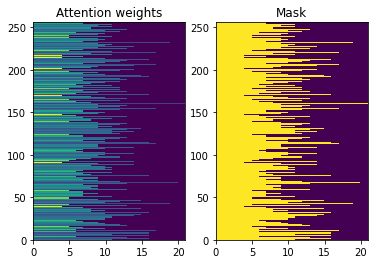

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


### Decoder Layer

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask
  )
  
  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(en_vectorization.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = en_vectorization(example_target_batch)

start_index = en_vectorization.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (256, 1, 5000)
state shape: (batch_size, dec_units) (256, 1024)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(en_vectorization.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[5:10]

array([['humans'],
       ['chips'],
       ['tools'],
       ['daniels'],
       ['unusual']], dtype='<U15')

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['include'],
       ['could'],
       ['protecting'],
       ['members'],
       ['fate']], dtype='<U15')

### Create Loss function class

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Connect all layers together to build model

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

### Tokenizing and convert ids to masks (keys)

In [ ]:
def _preprocess(self, input_text, target_text):
  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  target_mask = target_tokens != 0

  return input_tokens, input_mask, target_tokens, target_mask
  
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}
  
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

TrainTranslator._loop_step = _loop_step

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=fa_vectorization,
    output_text_processor=en_vectorization,
    use_tf_function=False
)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.686825>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6567607>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5945106>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.405448>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.7206836>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0878816>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2263665>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.499798>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.479482>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4927273>}


In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4782367>}

In [ ]:
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.456791>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4166408>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.342643>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2594495>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1944566>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.165964>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.173554>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.184169>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.169427>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.140668>}


....................................................................................................


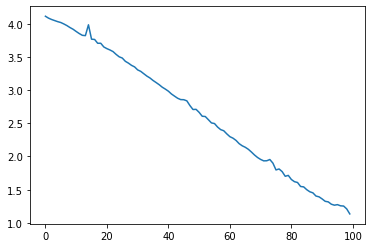

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

### Create translator instance

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=fa_vectorization,
    output_text_processor=en_vectorization
)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Log the results

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

### Train the model

In [ ]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
782/782 [==============================] - 426s 545ms/step - batch_loss: 0.4110
Epoch 2/3
782/782 [==============================] - 426s 545ms/step - batch_loss: 0.3584
Epoch 3/3
782/782 [==============================] - 423s 541ms/step - batch_loss: 0.3178


### Save the trained model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_translator.get_weights()

In [ ]:
# train_translator.save("drive/MyDrive/Colab Notebooks/nmt_model")


import pickle

with open('drive/MyDrive/Colab Notebooks/nmt_model_weights_loss_04709.pkl', 'wb') as outp:
    pickle.dump(train_translator.get_weights(), outp)


Text(0, 0.5, 'CE/token')

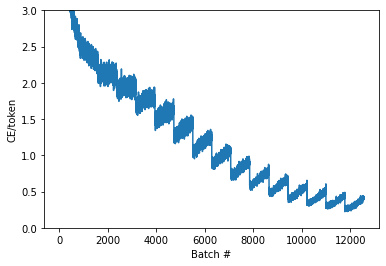

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True)
    )

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token=''
    )
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=fa_vectorization,
    output_text_processor=en_vectorization,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
def tokens_to_text(self, result_tokens):
  result_text_tokens = self.output_token_string_from_index(result_tokens)

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')

  result_text = tf.strings.strip(result_text)
  
  return result_text

Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=en_vectorization.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()[4].decode()

'gus twelve'

In [ ]:
def sample(self, logits, temperature):
  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  return new_tokens

Translator.sample = sample

In [ ]:
example_logits = tf.random.normal([5, 1, en_vectorization.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1714],
       [2572],
       [4918],
       [1598],
       [4696]])>

### Predict translation

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

Translator.translate = translate_unrolled

In [ ]:
lines_fa[202000: 202015]

['و طبق قانون اسپارتي ميمونيم و ميجنگيم .',
 'و ميميريم .',
 'دوره ي جديد آغاز شده .',
 'دوره آزادي .',
 'و همه خواهند فهميد که 300 اسپارتي .',
 'آخرين نفس هاشون را براي دفاع از اسپارتا دادن .',
 'دوست من .',
 'من تمام عمرم را تا الان بي هيچ تاسفي زندگي کرده بودم .',
 'اينو به اين خاطر نميگم که پسرم جونش را براي کشورش داده .',
 'بلکه به اين خاطر که هيچوقت بهش نگفتم که اونو از همه بيشتر دوست داشتم .',
 'اينکه شرافتمندانه در کنار من ايستادگي کرد .',
 'و اينکه اون همه خوبي هايي که در من بود را در خودش داشت .',
 'قلب من براي از دست دادن پسرت شکسته است .',
 'من قلبم را از نفرت پر کرده ام .',
 'داليوس .']

In [ ]:
input_text = tf.constant([
    "دوره ي جديد آغاز شده .",
    "دوست من .", 
    "من قلبم را از نفرت پر کرده ام ."
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print(result['text'][2].numpy().decode())

the new journey is just begun .
my friend .
ive abandoned my heart , and .


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

### Save model

In [ ]:
tf.saved_model.save(translator, '/content/drive/MyDrive/Colab Notebooks/fa_en_translator_model',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/assets


In [ ]:
!sudo apt-get install rar

In [ ]:
!rar a fa_en_translator_model.rar "/content/drive/MyDrive/Colab Notebooks/fa_en_translator_model"


RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive fa_en_translator_model.rar

Adding    /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/variables/variables.data-00000-of-00001       4%  9% 14% 19% 24% 29% 34% 39% 44% 49% 54% 59% 64% 69% 74% 79% 84% 89% 93%  OK 
Adding    /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/variables/variables.index      93%  OK 
Adding    /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/saved_model.pb      98% 99%  OK 
Adding    /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/variables       OK 
Adding    /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model/assets       OK 
Adding    /content/drive/MyDrive/Colab Notebooks/fa_en_translator_model       OK 
Done


In [ ]:
!cp fa_en_translator_model.rar "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
translator = tf.saved_model.load('drive/MyDrive/Colab Notebooks/fa_en_translator_model')

### Test model

In [ ]:
input_text = tf.constant([
    "دوره ي جديد آغاز شده .",
    "دوست من .", 
    "من قلبم را از نفرت پر کرده ام ."
])

results = translator.tf_translate(input_text)

for result in results['text']:
  print(result.numpy().decode())

the new journey is the new king .
my friend .
i have lost my heart of loving .


In [ ]:
!head -n20 TEP.en-fa.en

raspy breathing .
dad .
maybe its the wind .
no .
stop please stop .
you have a week , evans then well burn the house .
william .
god damn it , william .
god damn it put that down .
let go .
its the last feed weve got .
ill take care of this .
no , you wont .
herds over the ridge by now . you go get cleaned up .
you lied to me , dan .
you told me we made payments to hollander . we did .
so , how do you think we bought feed , alice . three months water , the medicine for mark .
i had a choice between our family and paying them down .
were supposed to make decisions together .
would you have made anything different .


In [ ]:
!head -n20 TEP.en-fa.fa

صداي خر خر .
پدر .
شايد صداي باد باشه .
نه .
دست نگه داريد خواهش ميکنم دست نگه داريد .
اوانز تو فقط يک هفته وقت داري وگرنه خونتو خواهيم سوزوند .
ويليام .
لعنتي . ويليام 8 .
لعنت به تو . اونو بذار زمين .
بذار برم .
اين آخرين علوفه اي بود که ما داشتيم .
من خودم اين کارو انجام ميدهم .
نه تو نميکني .
گله را آوردم بيرون الان . تو برو اونجا را تميز کن .
تو به من دروغ گفتي دن .
تو به من گفتي قرضمونو به هلندر پرداخت کرديم . ما پرداخت کرديم .
خب پس تو فکر ميکني ما چطوري علوفه خريديم سه ماه آب خرج دارو مارک .
من فقط يک انتخاب بين خانوادم و پرداخت قرض اونا داشتم .
ما قرار بود تصميماتو با هم بگيريم .
مگه تو تصميمه ديگه اي ميگرفتي .


In [ ]:
!cat TEP.en-fa.fa | wc -l
!cat TEP.en-fa.en | wc -l

612086
612086


In [ ]:
!head -n30 en-fa.tmx

<?xml version="1.0" encoding="UTF-8" ?>
<tmx version="1.4">
<header creationdate="Sun Mar  4 00:48:54 2018"
          srclang="en"
          adminlang="en"
          o-tmf="unknown"
          segtype="sentence"
          creationtool="Uplug"
          creationtoolversion="unknown"
          datatype="PlainText" />
  <body>
    <tu>
      <tuv xml:lang="en"><seg>raspy breathing .</seg></tuv>
      <tuv xml:lang="fa"><seg>صداي خر خر .</seg></tuv>
    </tu>
    <tu>
      <tuv xml:lang="en"><seg>maybe its the wind .</seg></tuv>
      <tuv xml:lang="fa"><seg>شايد صداي باد باشه .</seg></tuv>
    </tu>
    <tu>
      <tuv xml:lang="en"><seg>stop please stop .</seg></tuv>
      <tuv xml:lang="fa"><seg>دست نگه داريد خواهش ميکنم دست نگه داريد .</seg></tuv>
    </tu>
    <tu>
      <tuv xml:lang="en"><seg>you have a week , evans then well burn the house .</seg></tuv>
      <tuv xml:lang="fa"><seg>اوانز تو فقط يک هفته وقت داري وگرنه خونتو خواهيم سوزوند .</seg></tuv>
    </tu>
    <tu>
      <tuv 